将基于 **PyTorch** 实现的 SCN（随机配置网络）扩展为脉冲神经网络（SNN），需引入脉冲神经元模型（如 LIF）、时间动态编码和解码机制，并调整监督逻辑以适应脉冲信号的稀疏性和时序特性。以下是详细的分步思路和完整代码实现。

---

### **1. 核心扩展思路**

#### **(1) 替换神经元模型**
- **ANN → SNN**：将 SCN 中的激活函数（如 Sigmoid）替换为脉冲神经元模型（如 Leaky Integrate-and-Fire, LIF）。
- **时间步展开**：在多个时间步上模拟膜电位动态和脉冲发放。

#### **(2) 输入脉冲编码**
- **静态数据 → 脉冲序列**：使用泊松编码（Poisson Encoding）将输入数据转换为脉冲序列。

#### **(3) 动态增量构建的适配**
- **隐层节点的脉冲特性**：候选节点的输出不再是激活值，而是脉冲发放率。
- **监督条件调整**：基于脉冲发放率计算误差和参数筛选条件。

#### **(4) 输出解码**
- **脉冲发放率 → 连续值**：将脉冲序列解码为连续输出（如平均发放率）。

---

### **2. 完整代码实现**

#### **(1) 定义 LIF 神经元模块**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.linalg import pinv

class LIFNeuron(nn.Module):
    def __init__(self, tau=10.0, V_th=1.0, V_reset=0.0):
        super(LIFNeuron, self).__init__()
        self.tau = tau          # 膜时间常数
        self.V_th = V_th        # 发放阈值
        self.V_reset = V_reset  # 复位电位
        self.spike = None       # 脉冲输出
        self.mem_pot = None     # 膜电位

    def forward(self, x, dt=1.0):
        if self.mem_pot is None:
            self.mem_pot = torch.zeros_like(x)
        # 更新膜电位
        self.mem_pot += (-self.mem_pot + x) / self.tau * dt
        # 生成脉冲
        self.spike = (self.mem_pot >= self.V_th).float()
        self.mem_pot = self.mem_pot * (1 - self.spike) + self.V_reset * self.spike
        return self.spike

#### **(2) 脉冲编码器（泊松编码）**

In [3]:
class PoissonEncoder(nn.Module):
    def __init__(self, T=10):
        super(PoissonEncoder, self).__init__()
        self.T = T  # 时间步数

    def forward(self, x):
        # 将输入数据归一化到 [0, 1]，生成脉冲序列
        x_norm = torch.clamp(x, 0, 1)
        spikes = torch.rand(self.T, *x_norm.shape, device=x.device) < x_norm.unsqueeze(0)
        return spikes.float()

#### **(3) 脉冲 SCN 模块**

In [6]:
class SNN_SCN(nn.Module):
    def __init__(self, input_dim, output_dim, T=10, delta=1, Lambda_range=[0.5, 1.0], Tmax=10, c=1e-4, r=0.9):
        super(SNN_SCN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.T = T              # 时间步数
        self.delta = delta      # 每次添加的节点数
        self.Lambda_range = Lambda_range
        self.Tmax = Tmax        # 候选参数生成次数
        self.c = c              # 正则化系数
        self.r = r              # 监督机制衰减系数
        self.encoder = PoissonEncoder(T=self.T)
        self.hidden_weights = []  # 隐层权重
        self.hidden_biases = []   # 隐层偏置
        self.output_weight = None # 输出权重
        self.lif = LIFNeuron()

    def forward(self, x):
        # 输入编码为脉冲序列 [T, B, D]
        x_spikes = self.encoder(x)
        # 计算隐层脉冲发放率
        H_rate = []
        for w, b in zip(self.hidden_weights, self.hidden_biases):
            h_spikes = []
            for t in range(self.T):
                input_current = x_spikes[t] @ w.T + b.T
                h_spike = self.lif(input_current)
                h_spikes.append(h_spike)
            H_rate.append(torch.stack(h_spikes).mean(dim=0))  # 平均发放率
        H = torch.cat(H_rate, dim=1) if H_rate else torch.zeros(x.size(0), 0)
        # 拼接输入和隐层输出
        A = torch.cat([x, H], dim=1) if self.delta else H
        return A @ self.output_weight

    def incremental_train(self, X, Y, Lmax=100, tol=1e-3):
        device = X.device
        X_poisson = self.encoder(X)  # 输入编码为脉冲序列 [T, B, D]
        e = Y.clone()
        L = 0

        while L < Lmax and torch.norm(e) > tol:
            if L % 1 == 0:
                print('#L: {}\t RMSE: {:.4f} \r'.format(L, torch.norm(e)))
            candidate_weights = []
            candidate_biases = []
            ksi_list = []

            for _ in range(self.Tmax):
                Lambda = torch.FloatTensor(1).uniform_(*self.Lambda_range).item()
                w = Lambda * (2 * torch.rand(self.delta, self.input_dim, device=device) - 1)
                b = Lambda * (2 * torch.rand(self.delta, 1, device=device) - 1)
                # 计算候选节点的脉冲发放率
                h_spikes = []
                for t in range(self.T):
                    input_current = X_poisson[t] @ w.T + b.T
                    h_spike = self.lif(input_current)
                    h_spikes.append(h_spike)
                H_candidate = torch.stack(h_spikes).mean(dim=0)  # 平均发放率
                # 计算监督条件 ksi
                eTH = e.T @ H_candidate
                HTH = H_candidate.T @ H_candidate + self.c * torch.eye(H_candidate.size(1), device=device)
                ksi = (eTH @ pinv(HTH) @ eTH.T) - (1 - self.r) * (e.T @ e)
                if ksi > 0:
                    candidate_weights.append(w)
                    candidate_biases.append(b)
                    ksi_list.append(ksi)

            if not candidate_weights:
                self.r += torch.rand(1).item() * (1 - self.r)
                continue

            # 选择最优候选参数
            best_idx = torch.argmax(torch.tensor(ksi_list))
            self.hidden_weights.append(candidate_weights[best_idx])
            self.hidden_biases.append(candidate_biases[best_idx])
            L += self.delta

            # 更新隐层输出矩阵
            with torch.no_grad():
                H = self._get_hidden_output(X)
                A = torch.cat([X, H], dim=1) if self.delta else H
                self.output_weight = pinv(A) @ Y

            # 更新残差
            e = Y - A @ self.output_weight

    def _get_hidden_output(self, X):
        X_poisson = self.encoder(X)
        H_rate = []
        for w, b in zip(self.hidden_weights, self.hidden_biases):
            h_spikes = []
            for t in range(self.T):
                input_current = X_poisson[t] @ w.T + b.T
                h_spike = self.lif(input_current)
                h_spikes.append(h_spike)
            H_rate.append(torch.stack(h_spikes).mean(dim=0))
        return torch.cat(H_rate, dim=1) if H_rate else torch.zeros(X.size(0), 0)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.linalg import pinv
import numpy as np

def pseudo_inv(A, reg):
    """PyTorch版本的伪逆计算（带正则化的岭逆）"""
    identity = torch.eye(A.shape[1], device=A.device, dtype=A.dtype)  # 自动适配设备与数据类型
    A_p = torch.inverse(A.T @ A + reg * identity) @ A.T
    return A_p

# ---------------------- LIF神经元模型 ----------------------
class LIFNeuron(nn.Module):
    def __init__(self, tau=20.0, threshold=1.0, reset=0.0):
        super().__init__()
        self.tau = tau           # 膜时间常数
        self.threshold = threshold  # 发放阈值
        self.reset = reset       # 复位电位
        self.decay = torch.exp(torch.tensor(-1.0 / tau))  # 衰减因子

    def forward(self, x, V_prev=None, batch_size=1):
        """
        x: 输入脉冲序列 [batch, timesteps]
        V_prev: 初始膜电位 [batch, neurons]
        返回: 脉冲序列, 膜电位序列 [batch, timesteps, neurons]
        """
        timesteps = x.shape[1]
        batch_size = x.shape[0]
        spikes = torch.zeros((batch_size, timesteps, 1))
        voltages = torch.zeros((batch_size, timesteps, 1))

        if V_prev is None:
            V = torch.zeros(batch_size, 1)
        else:
            V = V_prev.clone()

        for t in range(timesteps):
            V = self.decay * V + x[:, t].unsqueeze(1)
            spike = (V >= self.threshold).float()
            V = V - spike * (self.threshold - self.reset)
            spikes[:, t] = spike
            voltages[:, t] = V

        return spikes, voltages

# ---------------------- 泊松编码器 ----------------------
class PoissonEncoder(nn.Module):
    def __init__(self, timesteps=20):
        super().__init__()
        self.timesteps = timesteps  # 时间步数

    def forward(self, x):
        """
        x: 输入数据 [batch, features], 值域[0,1]
        返回: 脉冲序列 [batch, features, timesteps]
        """
        batch_size, features = x.shape
        spikes = torch.rand(batch_size, features, self.timesteps, device=x.device)
        spike_train = (spikes < x.unsqueeze(-1)).float()
        return spike_train

# ---------------------- 增量式脉冲随机配置网络 ----------------------
class SNN_SCN(nn.Module):
    def __init__(self, input_dim, output_dim, timesteps=20, tau=20.0, threshold=1.0, 
                 Lambda_range=[0.5, 10], Tmax=10, r=0.9):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.timesteps = timesteps
        self.Lambda_range = Lambda_range
        self.Tmax = Tmax
        self.r = r
        
        # 神经元参数
        self.tau = tau
        self.threshold = threshold
        self.lif = LIFNeuron(tau, threshold)
        
        # 编码器
        self.encoder = PoissonEncoder(timesteps)
        
        # 动态存储结构
        self.hidden_weights = []   # 输入权重 [neuron, input_dim]
        self.hidden_biases = []    # 偏置 [neuron, 1]
        self.V_reset = []          # 膜电位复位值
        self.output_weight = None  # 输出权重 [hidden_dim, output_dim]

    def forward(self, x):
        """
        x: 输入数据 [batch, input_dim]
        返回: 输出脉冲序列 [batch, timesteps, output_dim]
        """
        # 泊松编码
        spike_input = self.encoder(x)  # [batch, input_dim, timesteps]
        
        # 累积所有隐藏层脉冲
        all_spikes = []
        for w, b in zip(self.hidden_weights, self.hidden_biases):
            # 计算突触电流
            current = torch.einsum('bij,jk->bik', spike_input, w.T) + b.T
            # 通过LIF神经元
            spikes, _ = self.lif(current.view(-1, self.timesteps), batch_size=x.size(0))
            all_spikes.append(spikes.view(-1, self.timesteps, 1))
        
        # 拼接所有脉冲输出
        if all_spikes:
            H = torch.cat(all_spikes, dim=-1)  # [batch, timesteps, hidden]
        else:
            H = torch.zeros(x.size(0), self.timesteps, 0, device=x.device)
        
        # 输出层（脉冲计数转换为速率）
        rate = H.mean(dim=1)  # [batch, hidden]
        return rate @ self.output_weight

    def incremental_train(self, X, Y, Lmax=100, tol=1e-3):
        device = X.device
        e = Y.clone()
        L = 0
        
        # 编码输入数据
        spike_X = self.encoder(X)  # [batch, input_dim, timesteps]
        
        while L < Lmax and torch.norm(e) > tol:
            print(f'L={L}, Error={torch.norm(e):.4f}')
            
            candidate_weights = []
            candidate_biases = []
            ksi_list = []
            
            # 生成候选神经元
            for _ in range(self.Tmax):
                Lambda = torch.FloatTensor(1).uniform_(*self.Lambda_range).item()
                w = Lambda * (2 * torch.rand(self.input_dim, device=device) - 1)
                b = Lambda * (2 * torch.rand(1, device=device) - 1)
                
                # 计算候选神经元的脉冲输出
                current = torch.einsum('bij,j->bi', spike_X, w) + b
                spikes, _ = self.lif(current.view(-1, self.timesteps), batch_size=X.size(0))
                rate = spikes.mean(dim=1)  # [batch, 1]
                
                # 监督条件
                H_candidate = rate
                if self.hidden_weights:
                    H = torch.cat([h.mean(dim=1) for h in self._get_hidden_output(spike_X)], dim=1)
                    A = torch.cat([H, H_candidate], dim=1)
                else:
                    A = H_candidate
                
                # 计算残差改进量
                beta = pinv(A) @ Y
                e_new = Y - A @ beta
                ksi = (torch.norm(e)**2 - torch.norm(e_new)**2) / torch.norm(e)**2
                
                if ksi > (1 - self.r):
                    candidate_weights.append(w)
                    candidate_biases.append(b)
                    ksi_list.append(ksi)
            
            if not candidate_weights:
                self.r += 0.1 * (1 - self.r)
                continue
            
            # 选择最佳候选
            best_idx = torch.argmax(torch.tensor(ksi_list))
            self.hidden_weights.append(candidate_weights[best_idx])
            self.hidden_biases.append(candidate_biases[best_idx])
            L += 1
            
            # 更新输出权重
            H_all = self._get_hidden_output(spike_X)
            if H_all:
                H_rates = torch.cat([h.mean(dim=1) for h in H_all], dim=1)
                self.output_weight = pinv(H_rates) @ Y
            
            # 更新残差
            with torch.no_grad():
                pred = self(X)
                e = Y - pred

    def _get_hidden_output(self, spike_X):
        outputs = []
        for w, b in zip(self.hidden_weights, self.hidden_biases):
            current = torch.einsum


---

### **3. 训练与测试示例**

#### **(1) 数据准备与训练**

In [9]:
# 生成回归数据
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=1000, n_features=5, noise=0.1)
y = y.reshape(-1, 1)

# 标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# 转为 PyTorch Tensor
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

# 初始化模型
model = SNN_SCN(input_dim=5, output_dim=1, T=10, delta=1)
model.incremental_train(X, y, Lmax=500, tol=0.01)

# 测试
with torch.no_grad():
    y_pred = model(X)
    test_rmse = torch.sqrt(torch.mean((y_pred - y)**2))
    print(f"Test RMSE: {test_rmse:.4f}")

TypeError: SNN_SCN.__init__() got an unexpected keyword argument 'T'

#### **(2) 分类任务扩展**

In [ ]:
class SNN_SCN_Classifier(SNN_SCN):
    def __init__(self, input_dim, num_classes, **kwargs):
        super().__init__(input_dim, num_classes, **kwargs)

    def forward(self, x):
        logits = super().forward(x)
        return torch.softmax(logits, dim=1)

    def incremental_train(self, X, Y, Lmax=100, tol=1e-3):
        # 将标签转为 one-hot
        Y_onehot = F.one_hot(Y.squeeze().long(), num_classes=self.output_dim).float()
        super().incremental_train(X, Y_onehot, Lmax, tol)

---

### **4. 关键改进点**

#### **(1) 脉冲动态建模**
- **LIF 神经元**：通过 `LIFNeuron` 模块实现膜电位更新和脉冲发放。
- **时间步展开**：在 `forward` 和 `incremental_train` 中循环处理时间步。

#### **(2) 脉冲编码与解码**
- **泊松编码**：将输入数据转换为时间脉冲序列。
- **发放率解码**：通过平均脉冲发放率将脉冲信号转为连续值。

#### **(3) 监督机制适配**
- **基于发放率的误差**：在监督条件 `ksi` 的计算中使用脉冲发放率而非激活值。
- **动态参数选择**：候选参数的筛选基于脉冲发放率的误差贡献。

---

### **5. 进一步优化方向**

1. **替代梯度（Surrogate Gradient）**  
   为 LIF 神经元定义可微分的脉冲生成函数，支持端到端训练：
   ```python
   class SurrogateLIF(LIFNeuron):
       @staticmethod
       def _spike_function(x):
           return torch.sigmoid(5 * x)  # 替代梯度函数

       def forward(self, x, dt=1.0):
           # ... （同 LIFNeuron）
           self.spike = self._spike_function(self.mem_pot - self.V_th)
           return self.spike
   ```

2. **时空误差传播（STDP）**  
   引入脉冲时间依赖可塑性（Spike-Timing-Dependent Plasticity）调整权重：
   ```python
   def stdp_update(self, pre_spike, post_spike, eta=0.01):
       # 简化的 STDP 规则
       delta_w = eta * (pre_spike.T @ post_spike - post_spike.T @ pre_spike)
       for w in self.hidden_weights:
           w.data += delta_w
   ```

3. **多时间尺度优化**  
   调整膜时间常数 `tau` 和发放阈值 `V_th` 以适配不同任务。

---

### **总结**
通过以上扩展，原始的 SCN 被改造为一个基于脉冲神经网络的动态增量学习模型，保留了随机配置和监督机制的核心特性，同时引入了脉冲时序编码和 LIF 神经元动态。此框架可进一步结合现代 SNN 训练技术（如替代梯度、STDP）提升性能。

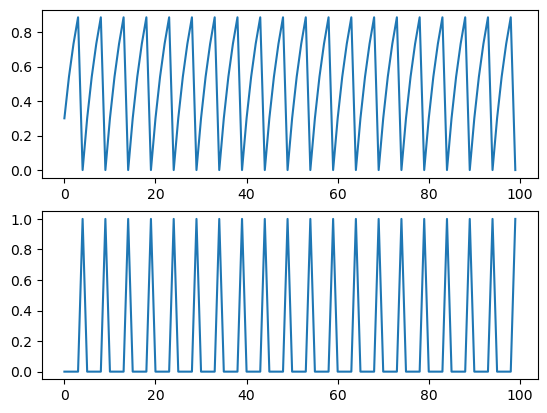

In [19]:
# -*- coding: utf-8 -*-
import numpy as np
from math import sqrt
from sklearn import preprocessing
from scipy import linalg as LA
import time
import matplotlib.pyplot as plt

class LIFNeuron:
    def __init__(self, threshold=1.0, tau=10.0, dt=0.1):
        self.threshold = threshold  # 脉冲发放阈值
        self.tau = tau  # 膜时间常数 这里看成膜时间常数的倒数
        self.dt = dt  # 时间步长
        self.membrane_potential = 0  # 膜电位
        self.H = 0 # 膜电位中间状态

    def reset(self):
        self.membrane_potential = 0

    def forward(self, I):
        # 更新膜电位: tau * dV/dt = -V + I
        # self.H = (1-self.tau)*self.membrane_potential + self.tau*I
        self.membrane_potential += (-self.membrane_potential + I) / self.tau * self.dt

        # 发放脉冲并重置
        if self.membrane_potential > self.threshold:
            spike = 1
            self.membrane_potential = 0  # 硬重置
        else:
            spike = 0
        return spike, self.membrane_potential
    
I = 1.5
spike_list = []
membrane_potential_list = []
LIF = LIFNeuron(threshold=1.0, tau=5.0, dt=1)
for t in range(100):
    spike, membrane_potential = LIF.forward(I)
    spike_list.append(spike)
    membrane_potential_list.append(membrane_potential)

plt.figure(1)
plt.subplot(211)
plt.plot(membrane_potential_list)
plt.subplot(212)
plt.plot(spike_list)
plt.show()



In [10]:
import numpy as np
def scaled_poisson_encoder(x, time_steps=100):
    # 缩放输入到[0.1, 0.9]
    x_scaled = (x + 10) / 20 #* 0.8 + 0.1
    print(f'scaled x: {x_scaled}')
    spikes = np.random.rand(time_steps) < x_scaled
    return spikes.astype(float)

# 示例：编码-5
spikes = scaled_poisson_encoder(np.array[-5,0,5,10])
print("脉冲数（非零）:", np.sum(spikes))

TypeError: 'builtin_function_or_method' object is not subscriptable

In [14]:
import numpy as np

def normalize_data(data):
    # 归一化数据到0-1范围
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def poissonencoding(data, timesteps):
    # 归一化数据
    normalized_data = normalize_data(data)
    
    # 将数据编码为泊松脉冲序列 [batchsize, features] -> [timesteps, batchsize, features]
    poisson_pulses = np.random.rand(timesteps, data.shape[0], data.shape[1]) < normalized_data[np.newaxis, :, :]
    
    return poisson_pulses

def poisson_encoding(data, time_steps=10):
    # 将数据编码为泊松脉冲序列 [batch_size, features] -> [time_steps, batch_size, features]
    return np.random.rand(time_steps, data.shape[0], data.shape[1]) < data[np.newaxis, :, :]

# 示例使用
data = np.array([[0.5, -1.2], [-0.3, 0.8]])
timesteps = 100
encoded_data = poissonencoding(data, timesteps)
encoded_data1 = poisson_encoding(data, timesteps)
# print(encoded_data)
print("脉冲数（非零）:", encoded_data.shape)
print("脉冲数（非零）:", encoded_data1.shape)

脉冲数（非零）: (100, 2, 2)
脉冲数（非零）: (100, 2, 2)


In [21]:
import numpy as np

def poisson_encoding(data, time_steps=10):
    """
    泊松编码函数，确保负数也能生成非零脉冲。
    参数:
        data: 输入数据，形状为 [batch_size, features]
        time_steps: 时间步数
    返回:
        spikes: 脉冲序列，形状为 [time_steps, batch_size, features]
    """
    # 1. 线性缩放数据到非零范围 [0.1, 0.9]
    # 动态计算数据范围，避免依赖固定假设（如-10到10）
    min_val = np.min(data)
    max_val = np.max(data)
    
    if max_val == min_val:
        # 所有数据相同，避免除以零，统一设为中性值0.5
        scaled_data = np.full_like(data, 0.5)
    else:
        # 缩放公式：将数据线性映射到 [0.1, 0.9]
        scaled_data = (data - min_val) / (max_val - min_val) * 0.8 + 0.1
    
    # 2. 生成泊松脉冲序列
    spikes = np.random.rand(time_steps, data.shape[0], data.shape[1]) < scaled_data[np.newaxis, :, :]
    return spikes.astype(float)

data = np.array([[-5], [3], [-10], [8]])  # 形状 [4, 1]
spikes = poisson_encoding(data, time_steps=1000)

# 统计脉冲数量（应全为非零）
pulse_counts = np.sum(spikes, axis=0)
print("脉冲数量统计（每个样本）:\n", pulse_counts)

脉冲数量统计（每个样本）:
 [[321.]
 [645.]
 [ 91.]
 [905.]]


(800, 1) (800, 1) (300, 1) (300, 1)


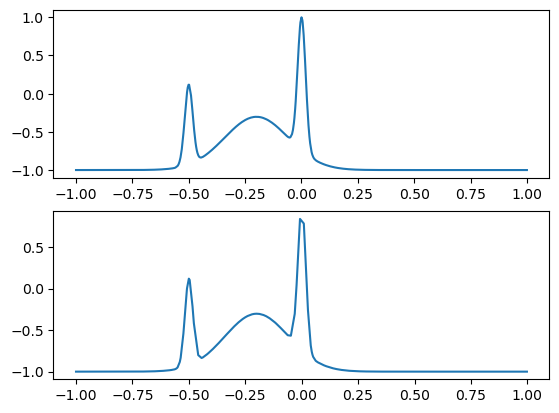

(800, 1) (800, 1)


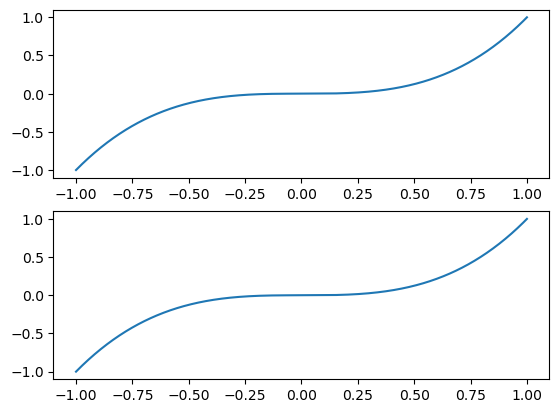

In [29]:
import scipy.io as scio
from matplotlib import pyplot as plt
Dataset = scio.loadmat('Demo_data.mat')
train_data = Dataset['P1']
train_label = Dataset['T1']
test_data = Dataset['P2']
test_label = Dataset['T2']

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)
plt.figure(1)
plt.subplot(211)
plt.plot(train_data, train_label)
plt.subplot(212)
plt.plot(test_data, test_label)
plt.show()

train_data = np.linspace(-1, 1, 800).reshape(-1, 1)
train_label = train_data ** 3# + np.random.normal(0, 0.1, train_data.shape)
print(train_data.shape, train_label.shape)
test_data = np.linspace(-1, 1, 800).reshape(-1, 1)
test_label = test_data ** 3# + np.random.normal(0, 0.1, test_data.shape)
print(test_data.shape, test_label.shape)
plt.figure(2)
plt.subplot(211)
plt.plot(train_data, train_label)
plt.subplot(212)
plt.plot(test_data, test_label)
plt.show()


In [33]:
# dataFile = './MNIST_bls.mat'
dataFile = './MNIST_784_onehot.mat'
# dataFile = './MNIST_precessed.mat'
data = scio.loadmat(dataFile)
train_data = np.double(data['train_x'])
train_label = np.double(data['train_y'])
test_data = np.double(data['test_x'])
test_label = np.double(data['test_y'])

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)
print(train_data[1])

(60000, 784) (60000, 10) (10000, 784) (10000, 10)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.   

CIFAR-10 Shapes:
Train data: (50000, 3072)
Train labels: (50000, 10)
Test data: (10000, 3072)
Test labels: (10000, 10)
[1. 1. 1. ... 1. 1. 1.]

CIFAR-100 Shapes:
Train data: (50000, 3072)
Train labels: (50000, 100)
Test data: (10000, 3072)
Test labels: (10000, 100)
